# __Projet NLP : Prédiction de note pour des avis de produits Amazon__
## <p style="color:blue;">1- Contexte et description des tâches</p>

Dans le cadre du projet de NLP, nous avons pour objectif de concevoir un système de classification de sentiments appliqué à des avis clients issus d’Amazon. L’objectif principal est de prédire automatiquement la note qu’un utilisateur a attribuée à un produit en se basant uniquement sur le titre et le contenu textuel de l’avis qu’il a rédigé.  
C'est un jeu de données qui est très connu et que nous avons trouvé sur kaggle : https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/data  
Il est téléchargeable directement sur le google drive suivant, dans le dossier amazon_full_review_csv.tar.gz : https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ

<p style="color:red;">A CONTINUER</p>


In [51]:
!pip install nltk pandas numpy matplotlib scikit-learn spacy tqdm seaborn
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\raphael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.4/12.8 MB 8.7 MB/s eta 0:00:02
     -- ------------------------------------- 0.7/12.8 MB 7.8 MB/s eta 0:00:02
     --- ------------------------------------ 1.0/12.8 MB 7.0 MB/s eta 0:00:02
     --- ------------------------------------ 1.2/12.8 MB 6.3 MB/s eta 0:00:02
     ---- ----------------------------------- 1.5/12.8 MB 6.5 MB/s eta 0:00:02
     ----- ---------------------------------- 1.8/12.8 MB 6.9 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.8 MB 6.8 MB/s eta 0:00:02
     ------- -------------------------------- 2.6/12.8 MB 6.8 MB/s eta 0:00:02
     -------- ------------------------------- 2.8/12.8 MB 6.6 MB/s eta 0:00:02
     --------- ------------------------------ 3.0/12.8 MB 6.4 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 6.5 MB/s eta 0:00:02
     ----------- ---------------------------- 3.8/12.8 MB 


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\raphael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### <p style="color:#d300ff;">- Les imports nécéssaires</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier


## <p style="color:blue;">2- Le dataset</p> 
Le dataset utilisé dans ce projet est un CSV qui contient exactement 3 millions d'avis utilisateurs Amazon en anglais, portant sur divers produits. Chaque ligne du fichier est structurée en trois colonnes :

- `label` : la note attribuée par l’utilisateur au produit (de 1 à 5 étoiles), qui va être notre donnée à prédire,

- `title` : le titre de l’avis,

- `review` : le contenu textuel de l’avis.


In [19]:
train_df = pd.read_csv("../amazon_review_full_csv/train.csv", header=None, names=["label","title","review"], 
                       on_bad_lines='skip',  # pour ignorer les lignes corrompues
                       encoding="utf-8")

In [20]:
#test affichage
train_df.head(5)


,label,title,review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [21]:
# Distrib des labels (pour l'instant de 1 à 5)
train_df['label'].value_counts()


label
3    600000
5    600000
4    600000
1    600000
2    600000
Name: count, dtype: int64

On voit qu'il y a 600 000 lignes pour chaque catégorie, de 1 à 5 étoiles. Donc au total 3 millions de commentaires.

### <p style="color:#d300ff;">- Objectif de classification/préparation des données</p>
Afin de simplifier la tâche de classification, on a regroupé les notes (qui allaient de 1 à 5) comme suit dans une quatrième colonne `label_3` :

- __négatif__ : notes de 1 ou 2 regroupés en 1,

- __neutre__ : note de 3 regroupés en 2,

- __positif__ : notes de 4 ou 5 regroupés en 3.

Cette transformation permet de formuler une tâche de classification en trois classes correspondant à des niveaux de sentiment.

In [25]:
def map_label(x):
    if x in [1,2]:
        return 1  # negatif
    elif x == 3:
        return 2  # neutre
    else:
        return 3  # positif

train_df['label_3'] = train_df['label'].apply(map_label)

train_df['label_3'].value_counts()


label_3
3    1200000
1    1200000
2     600000
Name: count, dtype: int64

Et enfin, pour éviter les erreurs liées aux titres/review vides, on a fusionné les 2 colonnes dans une cinquième nommée `full_review`.

Au final, on ne gardera que `label_3` et `full_review` car les autres nous seront inutiles.

In [26]:
print("Valeurs nulles par colonne:")
print(train_df.isna().sum())

Valeurs nulles par colonne:
label        0
title      188
review       0
label_3      0
dtype: int64


In [27]:
# Fusion des colonnes title et review
train_df['title'] = train_df['title'].fillna('') # Remplacer les valeurs nulles par une chaîne vide
train_df['full_review'] = train_df['title'] + ' ' + train_df['review'] 
train_df.head()

,label,title,review,label_3,full_review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...,2,more like funchuck Gave this to my dad for a g...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...,3,Inspiring I hope a lot of people hear this cd....
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,3,The best soundtrack ever to anything. I'm read...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...,3,Chrono Cross OST The music of Yasunori Misuda ...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...,3,Too good to be true Probably the greatest soun...


### <p style="color:#d300ff;">- Réduction du dataset</p>

Maintenant que nous avons regroupé nos labels en trois catégories et que nous avons rassemblé le titre et l'avis nous pouvons réduire notre dataset en supprimant les anciennes colonnes maintenant inutiles pour nos modèles.

In [28]:
# Suppression des colonnes inutiles
train_df = train_df[['label_3', 'full_review']]
train_df.head()

,label_3,full_review
0,2,more like funchuck Gave this to my dad for a g...
1,3,Inspiring I hope a lot of people hear this cd....
2,3,The best soundtrack ever to anything. I'm read...
3,3,Chrono Cross OST The music of Yasunori Misuda ...
4,3,Too good to be true Probably the greatest soun...


Pour éviter de prendre un temps très long à l'exécution du programme, on a décidé de réduire par 10 la taille du dataset et de se limiter à 900 000 avis (300 000 de chaque classe de note). Cela permet par la même occasion de rééquilibrer la répartition du nombre d'avis par classe, il y en avait deux fois moins pour la classe "neutre" après notre regroupement de catégories.

In [29]:
df_negatif  = train_df[train_df['label_3'] == 1].sample(n=300000, random_state=42)
df_neutre = train_df[train_df['label_3'] == 2].sample(n=300000, random_state=42)
df_positif = train_df[train_df['label_3'] == 3].sample(n=300000, random_state=42)

df_reduit = pd.concat([df_negatif, df_neutre, df_positif], ignore_index=True)
df_reduit = df_reduit.sample(frac=1, random_state=42).reset_index(drop=True)

df_reduit['label_3'].value_counts()

label_3
2    300000
3    300000
1    300000
Name: count, dtype: int64

## <p style="color:blue;">3- Nettoyage des données</p> 

Avant d'entraîner les modèles, nous avons prétraité les avis afin de les rendre exploitables par les algorithmes de machine learning.

1. Normalisation :
Cette étape consiste à mettre tout en minuscule, supprimer les caractères spéciaux, balises HTML, et homogénéiser le texte. Cela permet de réduire la variabilité inutile entre les mots (ex : "Excellent" = "excellent").

2. Tokenisation :
Le texte est ensuite découpé en mots appelées tokens. Cette étape est essentielle pour passer du texte brut à une représentation analysable.

3. Lemmatisation :
Chaque mot est réduit à sa forme canonique (ex : "running" devient "run"). Cela permet de regrouper les mots ayant le même sens malgré leurs variations grammaticales, et de réduire la dimension du vocabulaire.

### <p style="color:#d300ff;">- Outils utilisés pour ces étapes</p>

| Étape              | Description                                                                 | Outil / Librairie utilisée        |
|--------------------|------------------------------------------------------------------------------|------------------------------------|
| **Normalisation**  | Suppression des balises HTML, caractères spéciaux, mise en minuscule, etc.   | `re` (expressions régulières en Python) dans la fonction `basic_clean` |
| **Tokenisation**   | Découpage du texte en mots/tokens                                            | Réalisée automatiquement par `spaCy` via `nlp.pipe()` |
| **Lemmatisation**  | Réduction de chaque mot à sa forme canonique (ex : “running” → “run”)        | `spaCy` avec `token.lemma_` dans la fonction `spacy_batch_lemmatize` |

#### <p style="color:#d300ff;">Normalisation :</p>

In [30]:
def basic_clean(text):
    # Retirer les balises HTML
    text = re.sub(r'<.*?>', ' ', text)

    # Remplacer tout caractère qui n'est ni lettre ni ponctuation basique par un espace
    text = re.sub(r'[^a-zA-Z!?.,\'\s]', ' ', text)

    # Mise en minuscule
    text = text.lower()

    # Remplacer les espaces multiples par un seul espace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_reduit['clean_review'] = df_reduit['full_review'].apply(basic_clean)
df_reduit.head()

,label_3,full_review,clean_review
0,2,It was decent but needed a little more effort ...,it was decent but needed a little more effort ...
1,3,Kerry Classic! Kerry is one of the great fiddl...,kerry classic! kerry is one of the great fiddl...
2,2,Confusing! Love is beautifully written; howeve...,confusing! love is beautifully written however...
3,1,Prong disconnected when pulling from outlet Wh...,prong disconnected when pulling from outlet wh...
4,3,GREATEST MOVIE All of Celtic Thunders videos a...,greatest movie all of celtic thunders videos a...


#### <p style="color:#d300ff;">Tokenisation et lemmatisation :</p>

In [33]:
tqdm.pandas() # pour activer la barre de progression 

def spacy_batch_lemmatize(texts):
    lemmatized = []
    for doc in tqdm(nlp.pipe(texts, batch_size=1000, n_process=-1), total=len(texts)):
        lemmatized.append([token.lemma_ for token in doc if not token.is_space])
    return lemmatized

# df_reduit['lemmatized_tokens'] = spacy_batch_lemmatize(df_reduit['clean_review'].tolist())

On décide de garder les stopwords qui sont essentiels pour notre projet car il nous permettent parfois de déterminer si les mots précedent ou suivant sont positifs ou négatifs.

In [54]:
#df_reduit.to_csv("df_reduit_lemmatise.csv", index=False)
df_reduit = pd.read_csv("df_reduit_lemmatise.csv", encoding="utf-8")
df_reduit.head()


,label_3,full_review,clean_review,lemmatized_tokens
0,2,It was decent but needed a little more effort ...,it was decent but needed a little more effort ...,"['it', 'be', 'decent', 'but', 'need', 'a', 'li..."
1,3,Kerry Classic! Kerry is one of the great fiddl...,kerry classic! kerry is one of the great fiddl...,"['kerry', 'classic', '!', 'kerry', 'be', 'one'..."
2,2,Confusing! Love is beautifully written; howeve...,confusing! love is beautifully written however...,"['confusing', '!', 'love', 'be', 'beautifully'..."
3,1,Prong disconnected when pulling from outlet Wh...,prong disconnected when pulling from outlet wh...,"['prong', 'disconnect', 'when', 'pull', 'from'..."
4,3,GREATEST MOVIE All of Celtic Thunders videos a...,greatest movie all of celtic thunders videos a...,"['great', 'movie', 'all', 'of', 'celtic', 'thu..."


## <p style="color:blue;">4- Traitement des données</p> 
### <p style="color:#d300ff;">- Séparation</p>
Le dataset a été divisé en trois sous-ensembles distincts :

- `train_data` : pour l'entraînement du modèle

- `val_data` : pour ajuster les hyperparamètres et détecter un éventuel surapprentissage (overfitting)

- `test_data` : pour évaluer les performances finales du modèle

La séparation a été effectuée avec le paramètre **stratify** sur la variable label_3, afin de préserver la proportion des classes (négatif, neutre, positif) dans chaque jeu de données. Cela garantit une évaluation cohérente et représentative des performances du modèle sur toutes les classes.

### <p style="color:#d300ff;">- TF-IDF Vectorisation</p>

Avant d'appliquer la vectorisation TF-IDF et de split les données, il a été nécessaire de reconstituer les avis sous forme de texte à partir des listes de mots lemmatisés. Pour cela, chaque liste de tokens a été refusionné en une seule chaîne de caractères à l’aide de la méthode join, afin d'obtenir une phrase prête à être vectorisée enregistrée dans `text_final` :

In [ ]:
# Rejoindre les tokens lemmatisés en une seule chaîne de caractères
df_reduit['text_final'] = df_reduit['lemmatized_tokens'].apply(lambda x: ' '.join(eval(x)))
df_reduit.head()


,label_3,full_review,clean_review,lemmatized_tokens,text_final
0,2,It was decent but needed a little more effort ...,it was decent but needed a little more effort ...,"['it', 'be', 'decent', 'but', 'need', 'a', 'li...",it be decent but need a little more effort int...
1,3,Kerry Classic! Kerry is one of the great fiddl...,kerry classic! kerry is one of the great fiddl...,"['kerry', 'classic', '!', 'kerry', 'be', 'one'...",kerry classic ! kerry be one of the great fidd...
2,2,Confusing! Love is beautifully written; howeve...,confusing! love is beautifully written however...,"['confusing', '!', 'love', 'be', 'beautifully'...",confusing ! love be beautifully write however ...
3,1,Prong disconnected when pulling from outlet Wh...,prong disconnected when pulling from outlet wh...,"['prong', 'disconnect', 'when', 'pull', 'from'...",prong disconnect when pull from outlet when my...
4,3,GREATEST MOVIE All of Celtic Thunders videos a...,greatest movie all of celtic thunders videos a...,"['great', 'movie', 'all', 'of', 'celtic', 'thu...",great movie all of celtic thunder video be ama...


In [56]:
# 1) Séparation train/test+val
train_df, temp_df  = train_test_split(df_reduit, test_size=0.3, stratify=df_reduit['label_3'], random_state=42)

# 2) Séparation test et val (depuis les 30% restants)
val_df, test_df = train_test_split(temp_df , test_size=0.5, stratify=temp_df ['label_3'], random_state=42)


Une fois les textes reconstitués, nous avons appliqué la méthode TF-IDF vue en cours pour convertir ces textes en vecteurs numériques. Cette technique pondère chaque mot en fonction de son importance dans un document et dans l’ensemble du corpus, permettant de :

- Réduire l’influence des mots trop fréquents,

- Valoriser les termes discriminants pour les classes (négatif, neutre, positif),

- Obtenir une représentation vectorielle normalisée, prête à être utilisée par les modèles de classification.

In [57]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                        max_df=0.95, min_df=5, sublinear_tf=True) # on ignore les mots trop fréquents ou trop rares

# Apprentissage sur le train
X_train_tfidf = tfidf.fit_transform(train_df['text_final'])

# Application sur val et test
X_val_tfidf = tfidf.transform(val_df['text_final'])
X_test_tfidf = tfidf.transform(test_df['text_final'])

# Cibles
y_train = train_df['label_3']
y_val   = val_df['label_3']
y_test  = test_df['label_3']

In [58]:
print("X_train :", X_train_tfidf.shape)
print("X_val   :", X_val_tfidf.shape)
print("X_test  :", X_test_tfidf.shape)

X_train : (630000, 10000)
X_val   : (135000, 10000)
X_test  : (135000, 10000)


## <p style="color:blue;">5- Entraînement des modèles</p> 

Pour cette partie nous allons entraîner trois modèles de classification supervisée : 
- un naive bayes
- un SVM linéaire : LinearSVC
- un réseau de neurones MLP

### <p style="color:#d300ff;">- Modèle bayésien naïf</p>

C'est un bon modèle pour commencer car il est plutôt simpliste en terme de puissance de calcul tout en étant assez performant pour de la classification de texte. Il permet de classer les commentaires grace à des probabilités basées sur la fréquence d'apparition des mots. De plus il fonctionne bien avec les représentations TF-IDF.  
Cela nous permet d'avoir un bon modèle de référence que l'on va pouvoir comparer avec des modèles moins simplistes par la suite.  
On se sert du val set pour tester avec différents alpha et garder celui avec la meilleure précision.

=== Entraînement et validation du modèle Naive Bayes ===

Alpha = 0.1, Score = 0.668
Alpha = 0.5, Score = 0.668
Alpha = 1.0, Score = 0.668
Alpha = 2.0, Score = 0.668

Meilleur alpha trouvé : 2.0

Résultats sur la validation avec le meilleur modèle :
              precision    recall  f1-score   support

           1      0.693     0.679     0.686     45000
           2      0.573     0.592     0.582     45000
           3      0.743     0.733     0.738     45000

    accuracy                          0.668    135000
   macro avg      0.670     0.668     0.669    135000
weighted avg      0.670     0.668     0.669    135000


=== Évaluation finale sur le jeu de test ===
              precision    recall  f1-score   support

           1      0.692     0.678     0.685     45000
           2      0.573     0.593     0.583     45000
           3      0.740     0.730     0.735     45000

    accuracy                          0.667    135000
   macro avg      0.669     0.667     0.668    1350

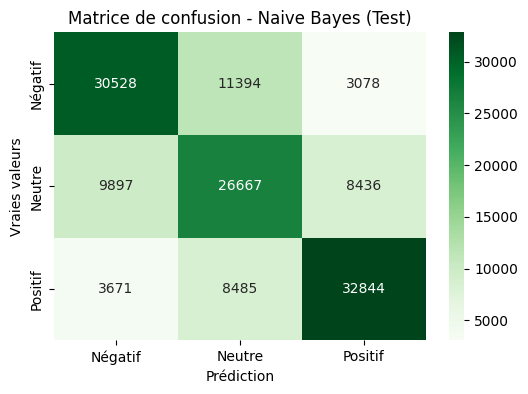

In [63]:
# 1. Création et entraînement du modèle initial
print("=== Entraînement et validation du modèle Naive Bayes ===\n")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# 2. Évaluation sur validation et ajustement
# Test avec différentes valeurs d'alpha pour voir si on peut améliorer les résultats
alphas = [0.1, 0.5, 1.0, 2.0]
best_score = 0
best_alpha = 1.0

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_tfidf, y_train)
    score = model.score(X_val_tfidf, y_val)
    print(f"Alpha = {alpha}, Score = {score:.3f}")
    
    if score > best_score:
        best_score = score
        best_alpha = alpha
        best_model = model

print(f"\nMeilleur alpha trouvé : {best_alpha}")

# Résultats de validation avec le meilleur modèle
y_val_pred = best_model.predict(X_val_tfidf)
print("\nRésultats sur la validation avec le meilleur modèle :")
print(classification_report(y_val, y_val_pred, digits=3))

# 3. Évaluation finale sur le test
print("\n=== Évaluation finale sur le jeu de test ===")
y_test_pred = best_model.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred, digits=3))

# Matrice de confusion sur test
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Négatif', 'Neutre', 'Positif'],
            yticklabels=['Négatif', 'Neutre', 'Positif'])
plt.xlabel("Prédiction")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion - Naive Bayes (Test)")
plt.show()

Si on regarde le recall :
- Classe 1 (Négatif) : 67,8% des avis réellement négatifs sont correctement identifiés
- Classe 2 (Neutre) : 59,3% des avis réellement neutres sont correctement identifiés
- Classe 3 (Positif) : 73,0% des avis réellement positifs sont correctement identifiés

L'erreur qui va être la plus critique ici ce sont les vrais négatifs prédit positifs, on peut voir sur la matrice de confusion ci-dessus qu'il y en a 3078 avec notre modèle naive bayes. C'est pareil pour les vrais positifs prédit négatifs, il y en 3671. Sans surprise on voit également que le modèle a plus de mal à predire les avis dit neutre, ils partagent du vocabulaire avec les deux autres classes.

### <p style="color:#d300ff;">- LinearSVC</p>

Le SVM classique (avec noyau) etant trop lent pour des données de grande dimension comme TF-IDF on va utiliser LinearSVC qui est optimisé pour le type de données qu'on possède (texte vectorisé).  
On va optimiser le paramètre C du SVM pour essayer de trouver le meilleur équilibre entre sous-apprentissage et surapprentissage. On gardera le modèle avec la meilleure précision.

=== Entraînement et validation du modèle LinearSVC ===



C:\Users\raphael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C = 0.1, Score = 0.716


C:\Users\raphael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C = 0.5, Score = 0.717


C:\Users\raphael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C = 1.0, Score = 0.716


C:\Users\raphael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C = 2.0, Score = 0.716

Meilleur C trouvé : 0.5

Résultats sur la validation avec le meilleur modèle :
              precision    recall  f1-score   support

           1      0.737     0.766     0.751     45000
           2      0.642     0.576     0.607     45000
           3      0.760     0.809     0.783     45000

    accuracy                          0.717    135000
   macro avg      0.713     0.717     0.714    135000
weighted avg      0.713     0.717     0.714    135000


=== Évaluation finale sur le jeu de test ===
              precision    recall  f1-score   support

           1      0.737     0.764     0.750     45000
           2      0.640     0.574     0.605     45000
           3      0.756     0.807     0.781     45000

    accuracy                          0.715    135000
   macro avg      0.711     0.715     0.712    135000
weighted avg      0.711     0.715     0.712    135000



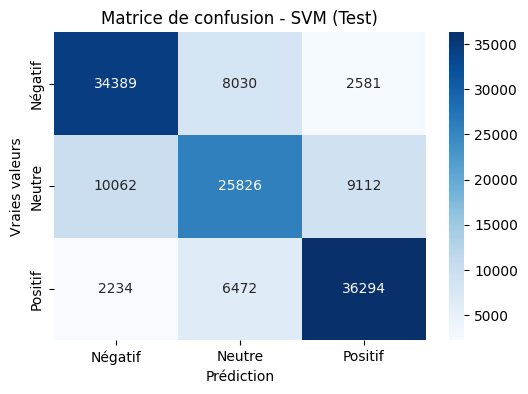

In [ ]:
# Entraînement et optimisation sur validation
# Test de différentes valeurs de C (paramètre de régularisation)
C_values = [0.1, 0.5, 1.0, 2.0]
best_score = 0
best_C = 1.0

for C in C_values:
    model = LinearSVC(C=C, random_state=42)
    model.fit(X_train_tfidf, y_train)
    score = model.score(X_val_tfidf, y_val)
    print(f"C = {C}, Score = {score:.3f}")
    
    if score > best_score:
        best_score = score
        best_C = C
        best_model = model

print(f"\nMeilleur C trouvé : {best_C}")

# Résultats sur la validation avec le meilleur modèle
y_val_pred = best_model.predict(X_val_tfidf)
print("\nRésultats sur la validation avec le meilleur modèle :")
print(classification_report(y_val, y_val_pred, digits=3))


=== Évaluation finale sur le jeu de test ===
              precision    recall  f1-score   support

           1      0.737     0.764     0.750     45000
           2      0.640     0.574     0.605     45000
           3      0.756     0.807     0.781     45000

    accuracy                          0.715    135000
   macro avg      0.711     0.715     0.712    135000
weighted avg      0.711     0.715     0.712    135000



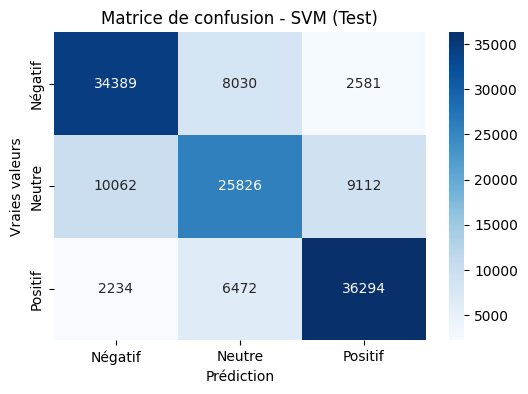

In [ ]:
# Évaluation finale sur le test
print("\n=== Évaluation finale sur le jeu de test ===")
y_test_pred = best_model.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred, digits=3))

# Matrice de confusion finale sur test
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Négatif', 'Neutre', 'Positif'],
            yticklabels=['Négatif', 'Neutre', 'Positif'])
plt.xlabel("Prédiction")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion - SVM (Test)")
plt.show()

#### Analyse des résultats
Après entraînement du modèle LinearSVC, le modèle atteint une accuracy globale de 71,7 % sur le meilleur score du jeu de validation ce qui est un résultat satisfaisant, il est de 71,5 % pour le test set.

Si on regarde le recall :
- Classe 1 (Négatif) : 76,4% des avis réellement négatifs sont correctement identifiés
- Classe 2 (Neutre) : 57,4% des avis réellement neutres sont correctement identifiés
- Classe 3 (Positif) : 80,7% des avis réellement positifs sont correctement identifiés

Effectivement, la matrice de confusion montre que :

- Les avis positifs sont bien classés, mais certains sont pris pour des neutres.

- Les avis neutres sont plus souvent mal classés, répartis entre négatif et positif.

- Les avis négatifs sont bien identifiés, avec quelques confusions vers neutre.

Cela confirme que la frontière entre négatif et positif est bien apprise mais que les avis neutres sont moins bien définis, ce qui vient surement du fait qu’ils partagent des mots avec les deux autres classes.

On va maintenant tenter d'améliorer les résultats en testant avec un modèle non-linéaire : réseau de neurones MLP

<br>

### <p style="color:#d300ff;">- MLP</p>

Contrairement à LinearSVC qui cherche une frontière linéaire, un MLP peut apprendre des relations non linéaires entre les mots et les sentiments.

Il combine les mots entre eux, ce qui est utile quand le sens vient de la structure ("not bad" ≠ "bad").  
Pour ce modèle nous ne pourrons pas optimiser en testant différents hyperparamètres avec l'ensembles de validation étant donné qu'il demande une grande puissance de calcul et donc une execution très longue.

In [43]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),  # une couche cachée de 100 neurones
    activation='relu',          # fonction d’activation non-linéaire ReLU
    solver='adam',              # algorithme d’optimisation efficace
    max_iter=20,                # nombre d’itérations limité pour tester rapidement
    random_state=42
)

mlp_model.fit(X_train_tfidf, y_train)


C:\Users\raphael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20, random_state=42)

In [44]:
# Evaluation
y_val_pred_mlp = mlp_model.predict(X_val_tfidf)

print("Classification Report (MLP):")
print(classification_report(y_val, y_val_pred_mlp, digits=3))


Classification Report (MLP):
              precision    recall  f1-score   support

           1      0.697     0.695     0.696     45000
           2      0.553     0.542     0.548     45000
           3      0.728     0.743     0.736     45000

    accuracy                          0.660    135000
   macro avg      0.659     0.660     0.660    135000
weighted avg      0.659     0.660     0.660    135000



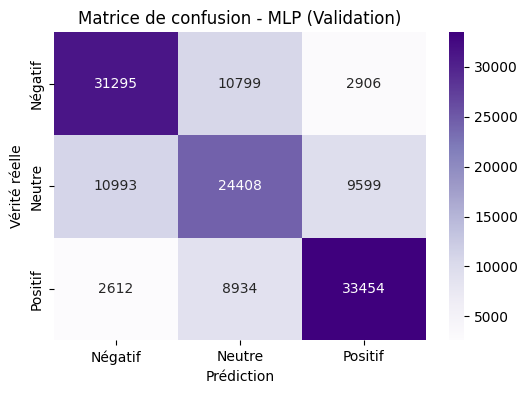

In [ ]:
conf_matrix = confusion_matrix(y_val, y_val_pred_mlp)

# Affichage
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Négatif', 'Neutre', 'Positif'],
            yticklabels=['Négatif', 'Neutre', 'Positif'])
plt.xlabel("Prédiction")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion - MLP (Validation)")
plt.show()


Nous testons directement sur l'ensemble de validation car nous n'avons pas adapté le modèle dessus. Donc pas besoin de se servir du test set.

#### Analyse des résultats
Nous avons testé un modèle MLP (réseau de neurones multi-couches) avec une architecture simple :

- 1 couche cachée de 100 neurones

- 20 itérations (epochs)

Sur le jeu de validation, le MLP atteint une accuracy globale de 65.9 %, ce qui est légèrement inférieur au modèle SVM (71.6 %).

Détail par classe :
- Classe 1 (négatif) : le modèle obtient un f1-score de 0.693, avec un bon équilibre précision/rappel.

- Classe 2 (neutre) : reste la classe la plus difficile à prédire, avec un f1-score de 0.551, souvent confondue avec les autres classes.

- Classe 3 (positif) : le modèle atteint un f1-score de 0.733, montrant une bonne capacité à détecter les avis positifs.

Le MLP réussit à capturer des patterns intéressants, mais reste moins performant que le SVM dans notre cas.

Et pour le recall :
- Classe 1 (Négatif) : 69,5% des avis réellement négatifs sont correctement identifiés
- Classe 2 (Neutre) : 54,2% des avis réellement neutres sont correctement identifiés
- Classe 3 (Positif) : 74,3% des avis réellement positifs sont correctement identifiés

On pourrait tenter d'améliorer les résultats en augmentant le nombre d'itérations à 50 (max_iter=50), ou encore d'ajouter une couche cachée de neurones, mais cela augmenterai également beaucoup le temps d'exécution.

### <p style="color:#d300ff;">- Améliorations possibles</p>
Pour tenter d'améliorer les résultats, nous avons d'abord essayé de modifier les paramètres pour optimiser l'apprentissage du modèle MLP :
- passer d'une couche de 100 neurones à deux couches avec 128 et 64 neurones respectivement (hidden_layer_sizes=(128,64)) et

- augmenter le nombre d'itérations à 50 (max_iter=50)

mais le temps d'exécution étant trop long, nous avons avorté l'apprentissage après plus d'une heure.

Il nous restait la solution de réduire de nouveau le dataset, chose que nous avons testé en gardant que 300 000 lignes du CSV.

1. Pour LinearSVC, l'accuracy globale a perdu 1% ce qui représente une perte très faible.

2. Pour MLP, l'accuracy globale a aussi baissé d'1% malgré l'optimisation des couches neurones et des itérations.
Les résultats étant légèrement moins efficace qu'avec l'ancien dataset de 900 000 lignes du CSV : nous avons décidé de garder le programme ci-dessus avec le dataset 900 000 lignes.

### <p style="color:#d300ff;">- Conclusion</p>
En conclusion, bien que le MLP offre plus de flexibilité et puisse théoriquement capturer des relations non linéaires plus complexes, le SVM reste ici le meilleur compromis entre performance, stabilité et rapidité d'entraînement, particulièrement adapté à la représentation vectorielle TF-IDF.

#### Evaluation finale
Comme le jeu de test n'a jamais été vu par le modèle, on obtient une évaluation finale et objective de la qualité du système développé :

In [46]:
y_test_pred = svm_model.predict(X_test_tfidf)

print("Résultats finaux sur le jeu de test :")
print(classification_report(y_test, y_test_pred, digits=3))


Résultats finaux sur le jeu de test :
              precision    recall  f1-score   support

           1      0.736     0.764     0.750     45000
           2      0.640     0.573     0.605     45000
           3      0.756     0.807     0.781     45000

    accuracy                          0.715    135000
   macro avg      0.711     0.715     0.712    135000
weighted avg      0.711     0.715     0.712    135000



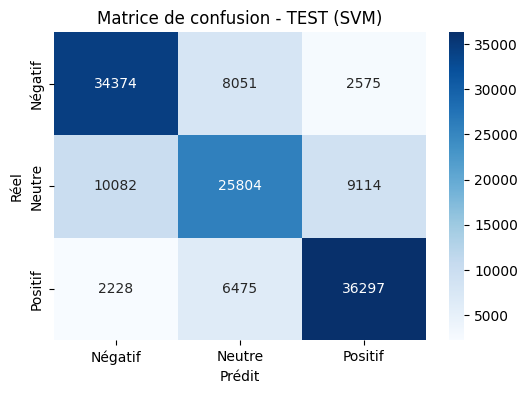

In [47]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Négatif', 'Neutre', 'Positif'],
            yticklabels=['Négatif', 'Neutre', 'Positif'])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - TEST (SVM)")
plt.show()

### Prédire votre propre avis avec le modèle SVM et entrant un titre et un avis

In [ ]:
def predict_sentiment(title, review):
    # Combiner les inputs
    full_review = f"{title} {review}"
    
    # Traiter les données avec les mêmes méthodes que précedemment
    cleaned_review = basic_clean(full_review)
    
    # Convertir en TF-IDF
    review_tfidf = tfidf.transform([cleaned_review])
    
    # Faire les prédictions
    prediction = svm_model.predict(review_tfidf)[0]
    
    # Mapping des classes à predire
    sentiment_map = {
        1: "Négatif (1-2 étoiles)",
        2: "Neutre (3 étoiles)", 
        3: "Positif (4-5 étoiles)"
    }
    
    return sentiment_map[prediction]

# Récupérer les inputs
print("Entrez votre avis sur un produit Amazon:")
title = input("Titre de l'avis (optionnel, appuyez sur Entrée si pas de titre): ")
review = input("Texte de l'avis: ")

# Calculer les prédictions
result = predict_sentiment(title, review)
print(title)
print(review)
print(f"\nPrédiction: {result}")

Entrez votre avis sur un produit Amazon:
great color and usefull
the sreen works very well and the price is okay for the quality

Prédiction: Positif (4-5 étoiles)


## <p style="color:blue;">6- Problèmes rencontrés</p> 

Lors du développement, nous avons eu plusieurs problèmes liés à la taille du dataset comme indiqué précédemment mais on peut notamment citer le problème de la tokenisation/lemmatisation où nous uilisions cette méthode :

<pre> 
def tokenize_and_lemmatize(text):
    doc = nlp(text)
    # Garder la ponctuation et les stopwords (important pour le sentiment)
    return [token.lemma_ for token in doc if not token.is_space]

tqdm.pandas()

train_df['lemmatized_tokens'] = train_df['clean_review'].progress_apply(tokenize_and_lemmatize)
</pre>
<br>

Cela ne traitait que 3300 lignes par minute, ce qui signifie que pour traiter les 3 millions de lignes, cela aurait pris plus de 15h ! 
Cela fait partie d'une des raisons pour laquelle nous avons choisi de réduire le dataset.

## <p style="color:blue;">7- Conclusion et possibles améliorations</p> 

Notre projet de classification de sentiment des avis Amazon a abouti à des résultats satisfaisants, avec une précision globale d'environ 71% pour notre meilleur modèle (SVM linéaire). Nous avons constaté que pour tous les modèles les meilleurs résultats sont sur le classe "positif" qui est donc plus facile à prédire.

### Points forts du projet :
Nous avons bien adapté nos étapes de prétraitement des données textuelles à notre jeux de données et notre problématique (nettoyage, lemmatisation). Ensuite nous avons vectoriser avec TF-IDF.
Nous avons choisit des modèle bien différents pour comparer leurs performances sur nos données. (Naive Bayes vs SVM vs MLP)
On constaté que c'est souvent une question d'équilibre entre performance, temps d'exécution et complexité.

### Limitations actuelles :
- Difficulté à classifier correctement les avis neutres, résultats sur cette classe pas très satisfaisant.
- Réduction nécessaire du dataset initial pour des raisons de performance, le dataset actuel reste très volumineux ce qui est handicapant pour certaines taches (lemmatisation par exemple) ou modèles comme le MLP.

### Amélioration possibles :

1. **Amélioration des features** :
   - Faire une normalisation plus inclusive, prendre en compte les émojis par exemple
   - Ajouter des features basées sur des lexiques de sentiment

2. **Optimisation des modèles** :
   - Explorer d'autres architectures de réseaux de neurones
   - Effectuer une recherche systématique d'hyperparamètres (GridSearch) mais cela demanderait une grande puissance de calcul

4. **Enrichissement de l'analyse** :
   - Ajouter une analyse des mots les plus discriminants par classe
   - Travailler d'avantage sur les cas identifiés d'erreur typiques pour mieux comprendre les limitations
